In [1]:
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import scipy.signal
import re
import lmfit
import rampy as rp
import matplotlib
import configparser

C:\Users\viann\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
config = configparser.ConfigParser()
config.read("raman_config.ini")

['raman_config.ini']

In [3]:
names_ech = ["E02", "893"]

# All physical parameters raman's related
regions_of_interest = np.array([(1100,1150),(1720,1760)]) # The regions where the baseline will be fitted
lb = 1100 # The lower boundary of interest
hb = 1800 # The upper boundary of interest

In [4]:
def read_sample(num_ech):
    """Reads all data related to a single sample"""
    filenames = glob.glob(f"Raman_data/{num_ech}/*/*.txt")
    dfs = (read_ech_file(num_ech, f) for f in filenames)
    return pd.concat(dfs)

infos_reg = {
    'name_zone': 'part(\d+)',
    'num_test': 'point(\d+)',
    'other': '__(.*)\(',
    'energy': '100_(.*)\)',
    'annealing': '(\d+)°C'
}

def extract_info(regex, filename):
    match = re.search(regex, filename)
    group = match.group(1) if match else np.NaN
    return pd.to_numeric(group, errors='ignore')
    
def read_ech_file(num_ech, filename):
    """Reads a single file"""
    df = pd.read_csv(filename, sep='\t', header=None, names=("shift", "intensity"))
    df['name_ech'] = num_ech
    df['trib'] = '_trib_' in filename
    infos = {name: extract_info(regex, filename) for name,regex in infos_reg.items()}
    for col_name, value in infos.items(): df[col_name] = value
    df['ID'] = (f"{num_ech} "
                f"{'' if 'trib' in filename else 'no'}trib "
                f"zone:{infos['name_zone'] if not np.isnan(infos['name_zone']) else '?'} "
                f"test:{infos['num_test']} "
                f"{'no_annealing' if np.isnan(infos['annealing']) else str(infos['annealing'])+'°C'} "
                f"energy:{infos['energy']}")
    return df

# Adding a smoothed intensity, for ploting smooth curves while displaying the raman
def smoother(x): return scipy.signal.savgol_filter(x, 39,3)

### CREATION OF THE DIFFERENT FUNCTIONS USED FOR RAMAN FITTING

def BWF(x,amp,freq,FWHM,q): # for spectral fit 
    amp_max = amp/(1+1/np.power(q,2))
    x_max = x + FWHM/(2*q)
    return amp_max*(1+2*(x_max-freq)/(q*FWHM))**2/(1+(2*(x_max-freq)/FWHM)**2)
    #  cf "Interpretation of Raman spectra of disordered and amorphous carbon"

def gaussian(x,amp,freq,FWHM): # for spectral fit
    return amp*np.exp(-np.log(2)*(2*(x-freq)/FWHM)**2)

def lorentz(x,amp,freq,FWHM):
    return amp*(1/(1+(2*(x-freq)/FWHM)**2))

def linear_fun(x, a, b) : return a + b*x

def residual(pars, x, data=None, eps=None):    
    def get_par(var, n): return pars[var.format(n)].value
    param_names = {
        gaussian: {'amp':'G_a{}', 'freq':'G_f{}', 'FWHM':'G_l{}'},
        BWF: {'amp':'B_a{}', 'freq':'B_f{}', 'FWHM':'B_l{}', 'q': 'B_q{}'},
        linear_fun: {'a': 'lin_a', 'b': 'lin_b'}
    }
    def get_peak(fun, n=None):
        return fun(x, **{
            name: get_par(value,n)
                for name, value in param_names[fun].items()  
        })
    gaussian_peaks = [get_peak(gaussian, n) for n in (1,2,3)]
    peaks = gaussian_peaks + [get_peak(BWF,1), get_peak(linear_fun)]
    model = sum(peaks) # The global model is the sum of the Gaussian peaks
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return [model] + peaks
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

In [5]:
df_raman = pd.concat(read_sample(ech) for ech in names_ech)
df_raman['intensity_smooth'] = df_raman.groupby('ID')['intensity'].transform(smoother)

C:\Users\viann\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Text(0.5, 1.0, 'Intensity no filter')

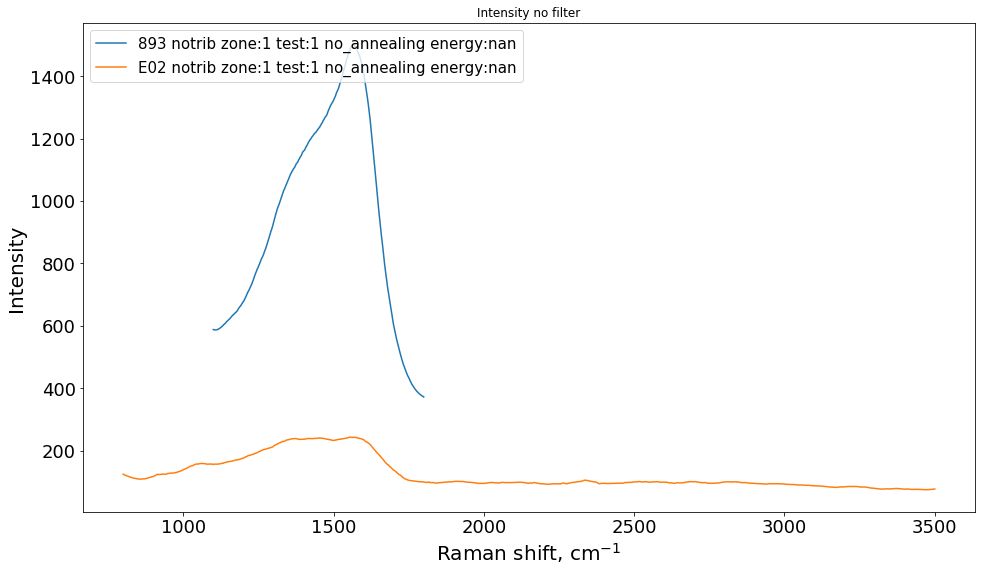

In [13]:
# SUPERIMPOSE THE SELECTED CURVES, JUST FOR PREVIEUW the selected curves

fig, ax = plt.subplots(figsize = (16,9))

# df_895_notrib = df_raman.query('name_ech == 911 and not trib')

for (name_ech, num_test, trib), df in df_raman.groupby(['name_ech', 'num_test', 'trib']):
    for label, df in df.groupby('ID'):
        df_plot = df.plot(
            kind = 'line',
            x = 'shift',
            y = 'intensity_smooth', 
            label = label,
            ax = ax,
            title = 'Sample ' + str((name_ech, trib))
        )

fig = df_plot.get_figure()
df_plot.set_xlabel('Raman shift, cm$^{-1}$', fontsize = 20)
df_plot.set_ylabel('Intensity', fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.title('Intensity no filter')      

893
E02


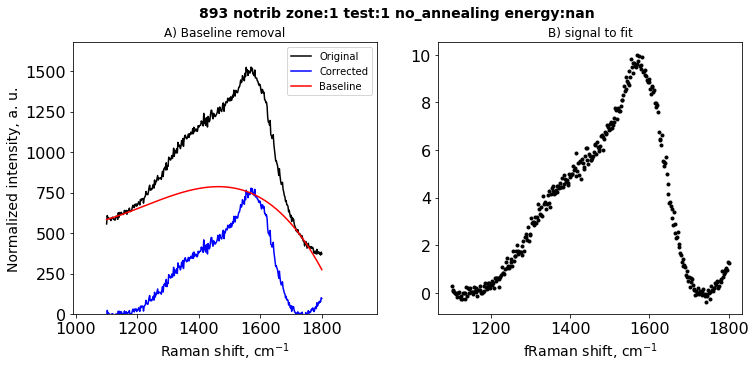

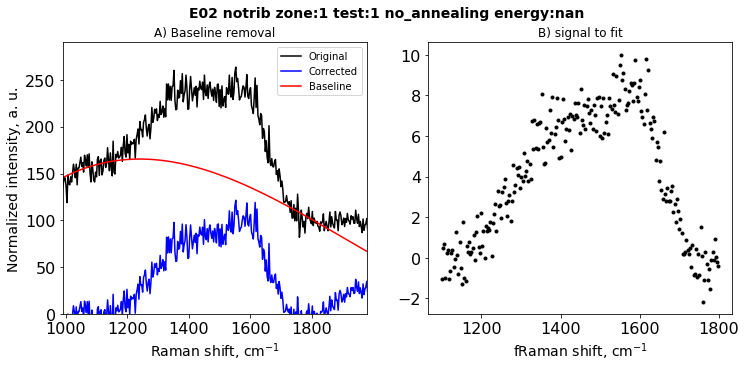

In [14]:
get_all_ech = True
selected_samples = []

# List of the sample to get the baseline for

fits_by_id = {}

for key, df in df_raman.groupby('ID'):
    name_ech = df.name_ech.unique()[0]
    is_true = (np.isin(key, selected_samples) or get_all_ech)
    show_plot_init = is_true
    base_line = is_true
    if base_line:
        x, y = df["shift"].values, df["intensity"].values
        y_corr, y_base = rp.baseline(
            x_input = x,
            y_input = y,
            bir=regions_of_interest,
            method='poly',
            polynomial_order=3
        )
        y_corr_flat = y_corr[:,0]
        in_boundaries = df["shift"].between(lb ,hb)
        x_fit, y_fit = x[in_boundaries], y_corr_flat[in_boundaries]
        y_fit = y_fit/np.amax(y_fit)*10
        fits_by_id[key] = pd.DataFrame({'x': x_fit, 'y': y_fit})
        # the relative errors after baseline subtraction
        ese0 = np.sqrt(abs(y_fit))/abs(y_fit) 
        # normalise spectra to maximum intensity, easier to handle 
        max_intensity = np.amax(y_fit)
        sigma = abs(ese0*y_fit) #calculate good ese
    
    # create a new plot for showing the spectrum
    if show_plot_init:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        inp = plt.plot(x,y,'k-',label='Original')
        # we use the sample variable because it is not already normalized...
        corr = plt.plot(x,y_corr,'b-',label='Corrected') 
        bas = plt.plot(x,y_base,'r-',label='Baseline')
        plt.xlim(0.9*lb,1.1*hb)
        plt.ylim(0,1.1*np.amax(y))
        plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
        plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
        plt.legend()
        plt.title('A) Baseline removal')

        plt.subplot(1,2,2)
        plt.plot(x_fit,y_fit,'k.')
        plt.xlabel("fRaman shift, cm$^{-1}$", fontsize = 14)
        plt.title('B) signal to fit')
        plt.suptitle(f"{key}", fontsize = 14,fontweight = 'bold')

In [8]:
G_a1 = [1,0,0]
G_f1 = [1180,900,1200] # d-sp3
G_l1 = [282,100,300]
G_a2 = [1,0,]
G_f2 = [1372,1365,1380] # D band
G_l2 = [262,0,300]
G_a3 = [0,0,0.001,]
G_f3 = [1562,1558,1568] # G band
G_l3 = [204,0,300]
B_a1 = [8,3,15]
B_f1 = [1562,1548,1568] # G band
B_l1 = [204,0,300]
B_q1 = [-10,-100,-0.1]
lin_a = [0,-0.001,0]
lin_b = [0,0,0.0000012]

In [9]:
params = lmfit.Parameters()
#               (Name,  Value,  Vary,   Min,  Max,  Expr)



# # GGB
# params.add_many(('G_a1',   1,   True,  0,      None,  None),
#                 ('G_f1',   1180,   True, 900,    1200,  None), # d-sp3
#                 ('G_l1',   282,   True,  100,   300,  None),
#                 ('G_a2',   1,   True,  0,      None,  None),
#                 ('G_f2',   1372,  True, 1365,   1380,  None), # D band
#                 ('G_l2',   262,   True,  0,   300,  None),  
#                 ('G_a3',   0,    True,    0,      0.001,  None),
#                 ('G_f3',   1562,  True, 1558,   1568,  None), # G band
#                 ('G_l3',   204,   True,  0,   300,  None),
#                 ('B_a1',   8,    True,    3,      None,  None),
#                 ('B_f1',   1562,  True, 1548,   1568,  None), # G band
#                 ('B_l1',   204,   True,  0,   300,  None),
#                 ('B_q1',   -10,   True,  -100,   -0.1,  None),
#                 ('lin_a', 0, True, -0.001, 0, None),
#                 ('lin_b', 0, True, 0, 0.0000012, None)
#                )

# # GGG
# params.add_many(('G_a1',   1,   True,  0,      None,  None),
#                 ('G_f1',   1180,   True, 900,    1200,  None), # d-sp3
#                 ('G_l1',   282,   True,  100,   300,  None),
#                 ('G_a2',   1,   True,  0,      None,  None),
#                 ('G_f2',   1372,  True, 1365,   1380,  None), # D band
#                 ('G_l2',   262,   True,  0,   300,  None),  
#                 ('G_a3',   8,    True,    0,      None,  None),
#                 ('G_f3',   1562,  True, 1558,   1568,  None), # G band
#                 ('G_l3',   204,   True,  0,   300,  None),
#                 ('B_a1',   0,    True,    0,      0.001,  None),
#                 ('B_f1',   1000,  True, 900,   1568,  None), # X band
#                 ('B_l1',   204,   True,  0,   300,  None),
#                 ('B_q1',   -100,   True,  -100,   -101,  None),
#                 ('lin_a', 0, True, -0.001, 0, None),
#                 ('lin_b', 0, True, 0, 0.0000012, None)
#                )


# GB
params.add_many(('G_a1',   1,   True,  0,      0.001,  None),
                ('G_f1',   1180,   True, 1174,    1186,  None), # d-sp3
                ('G_l1',   282,   True,  100,   300,  None),
                ('G_a2',   1,   True,  0,      None,  None),
                ('G_f2',   1372,  True, 1365,   1380,  None), # D band
                ('G_l2',   262,   True,  0,   300,  None),  
                ('G_a3',   3,   True,  0,      0.001,  None),
                ('G_f3',   1470, True, 1466,   1474,  None), # F band
                ('G_l3',   197,   True,  100,   300,  None), 
                ('B_a1',   8,    True,    3,      None,  None),
                ('B_f1',   1562,  True, 1558,   1568,  None), # G band
                ('B_l1',   204,   True,  0,   300,  None),
                ('B_q1',   -10,   True,  -100,   -0.1,  None),
                ('lin_a', 0, True, -5, 0, None),
                ('lin_b', 0, True, 0, 0.0012, None)
               )

# # GGGB
# params.add_many(('G_a1',   1,   True,  0,      None,  None),
#                 ('G_f1',   1180,   True, 1174,    1186,  None), # d-sp3
#                 ('G_l1',   282,   True,  100,   300,  None),
#                 ('G_a2',   1,   True,  0,      None,  None),
#                 ('G_f2',   1372,  True, 1365,   1380,  None), # D band
#                 ('G_l2',   262,   True,  0,   300,  None),  
#                 ('G_a3',   3,   True,  0,      None,  None),
#                 ('G_f3',   1470, True, 1466,   1474,  None), # F band
#                 ('G_l3',   197,   True,  100,   300,  None), 
#                 ('B_a1',   8,    True,    3,      None,  None),
#                 ('B_f1',   1562,  True, 1558,   1568,  None), # G band
#                 ('B_l1',   204,   True,  0,   300,  None),
#                 ('B_q1',   -10,   True,  -100,   -0.1,  None),
#                 ('lin_a', 0, True, -5, 0, None),
#                 ('lin_b', 0, True, 0, 0.0012, None)
#                )

In [10]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

list_all_params = []
list_all_areas = []
list_ID = []
list_rchi2 = []
list_results = []

for key, df in df_raman.groupby('ID'):
    name_ech = df.name_ech.unique()[0]
    show_plot_fit = False
    fits = fits_by_id[key]
    x_fit,y_fit = fits.x.values, fits.y.values
    # RAMAN FITING
    list_ID.append(key)
    # we constrain the positions
    position_params = ('G_f1','G_f2','G_f3','B_f1')
    for pname in position_params:
        params[pname].vary = False

    algo = 'needler'   
    result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit))
    # fit data with  nelder model from scipy

    # we release the positions but contrain the FWMH and amplitude of all peaks 
    for pname in ('G_f1','G_f2','G_f3','B_f1'):
        params[pname].vary = True

    algo = 'needler'
    #we fit twice
    result2 = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit))
    list_results.append(result2.params)
    model = lmfit.fit_report(result2.params)
    yout, peak1,peak2,peak3,peak4,linear = residual(result2.params,x_fit)# the different peaks

    list_params = []
    for item in dict(result2.params).values():
        para = re.split(',',str(item))[1]
        if re.search('fixed', para):
            para = re.search('=(.*) \(',para).groups()[0]
        list_params.append(float(para))            
    list_all_params.append(list_params)

    list_areas = [np.trapz(item)/np.trapz(peak1 + peak2 + peak3 + peak4-linear) for item in [peak1, peak2, peak3, peak4-linear]] 
    list_all_areas.append(list_areas)
    if show_plot_fit:
        ##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
        plt.figure(figsize = (8,6))
        y_fit_s = scipy.signal.savgol_filter(y_fit, 29, 3)
        plt.plot(x_fit,y_fit,'k-')
        plt.plot(x_fit,yout,'r-')
        plt.plot(x_fit,peak1,'b-')
        plt.plot(x_fit,peak2,'b-')
        plt.plot(x_fit,peak3,'b-')
#         plt.plot(x_fit,-linear,'b--')
        plt.plot(x_fit,peak4+linear,'b-')
        plt.xlim(lb,hb)
        #plt.ylim(0,12)
        plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
        plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
        plt.title(f"{key}" ,fontsize = 14,fontweight = "bold")
        key = key.replace(":", "_")
        plt.savefig(f'Raman_fit_test/Raman_fit_{name_ech}/{key}.png')
        
infos_fit_raman_all = pd.DataFrame()
for (list_params, name_ID, list_areas) in zip(list_all_params, list_ID, list_all_areas):
    df = pd.DataFrame()
    l1 = [[i] for i in list(params.values())]
    l2 = [[i] for i in list_params]
    df['ID'], df['G1_amp_ini'], df['G1_amp'], df['G1_freq_ini'], df['G1_freq'], df['G1_FWHM_ini'], df['G1_FWHM'], \
    df['G2_amp_ini'], df['G2_amp'], df['G2_freq_ini'], df['G2_freq'], df['G2_FWHM_ini'], df['G2_FWHM'], \
    df['G3_amp_ini'], df['G3_amp'], df['G3_freq_ini'], df['G3_freq'], df['G3_FWHM_ini'], df['G3_FWHM'], \
    df['B1_amp_ini + cst'], df['B1_amp + cst'], df['B1_freq_ini'], df['B1_freq'], df['B1_FWHM_ini'], df['B1_FWHM'], \
    df['B1_q_ini'], df['B1_q'], df['cst_a_ini'], df['cst_a'], df['cst_b_ini'], df['cst_b'] \
    = list([[name_ID]]) + [x for xy in zip(l1,l2) for x in xy]
    df['B1_amp'] =  (df['B1_amp + cst'] + (df['cst_a'] + df['B1_freq']*df['cst_b']))
    
    df['G1_area'], df['G2_area'], df['G3_area'], df['B1_area'] = [[i] for i in list_areas]
    infos_fit_raman_all = infos_fit_raman_all.append(df, ignore_index=True)


In [11]:
infos_fit_raman_all

,ID,G1_amp_ini,G1_amp,G1_freq_ini,G1_freq,G1_FWHM_ini,G1_FWHM,G2_amp_ini,G2_amp,G2_freq_ini,...,B1_q,cst_a_ini,cst_a,cst_b_ini,cst_b,B1_amp,G1_area,G2_area,G3_area,B1_area
0,893 notrib zone:1 test:1 no_annealing energy:nan,"<Parameter 'G_a1', 0.001, bounds=[0:0.001]>",0.000187,"<Parameter 'G_f1', 1180, bounds=[1174:1186]>",1180.221863,"<Parameter 'G_l1', 282, bounds=[100:300]>",249.532747,"<Parameter 'G_a2', 1, bounds=[0:inf]>",2.529593,"<Parameter 'G_f2', 1372, bounds=[1365:1380]>",...,-4.950479,"<Parameter 'lin_a', 0, bounds=[-5:0]>",-2.864726,"<Parameter 'lin_b', 0, bounds=[0:0.0012]>",0.0012,9.742701,0.000009,0.111791,0.000001,0.888199
1,E02 notrib zone:1 test:1 no_annealing energy:nan,"<Parameter 'G_a1', 0.001, bounds=[0:0.001]>",0.000912,"<Parameter 'G_f1', 1180, bounds=[1174:1186]>",1179.962002,"<Parameter 'G_l1', 282, bounds=[100:300]>",250.983410,"<Parameter 'G_a2', 1, bounds=[0:inf]>",3.735912,"<Parameter 'G_f2', 1372, bounds=[1365:1380]>",...,-3.606216,"<Parameter 'lin_a', 0, bounds=[-5:0]>",-3.905387,"<Parameter 'lin_b', 0, bounds=[0:0.0012]>",0.0012,8.363795,0.000032,0.125757,0.000016,0.874194


In [12]:
df_raman_unique_ID = df_raman.drop_duplicates('ID')   
infos_fit_raman_all = infos_fit_raman_all.merge(df_raman_unique_ID)
infos_fit_raman_all['I_D/I_G'] = infos_fit_raman_all['G2_amp']/infos_fit_raman_all['B1_amp']
infos_fit_raman_all.iloc[:, : 50]
infos_fit_raman_all_index = infos_fit_raman_all.set_index('ID')
infos_fit_raman_all.T.to_csv(f'Raman_fit_test/infos_fit_raman_all.csv', sep='\t')